In [ ]:
# Install dependencies and 
!pip install albumentations==0.4.6
!pip install pycocotools --quiet

# Clone TorchVision repo and copy helper files
!git clone https://github.com/pytorch/vision.git
%cd vision
!git checkout v0.3.0
%cd ..
!copy ./vision/references/detection/utils.py .
!copy ./vision/references/detection/transforms.py .
!copy ./vision/references/detection/coco_eval.py .
!copy ./vision/references/detection/engine.py .
!copy ./vision/references/detection/coco_utils.py .

In [7]:
# basic python and ML Libraries
import os
import random
import numpy as np
import pandas as pd
import math

# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# We will be reading images using OpenCV
import cv2

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms as torchtrans
from torchvision.models.detection.fcos import FCOSHead  

# helper libraries
from engine import train_one_epoch, evaluate
import utils
import transforms as T

# for image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import xml.etree.ElementTree as ET

In [8]:
files_dir = r"D:\Abdallah\Venvs\tvenv\notebook\imgs"

class NeutrophilDataset(torch.utils.data.Dataset):
    def __init__(self, files_dir, transforms=None):
        self.transforms = transforms
        self.files_dir = files_dir
        
        #sorting images
        #to get images, the last 4 characters are checked for ".jpg"
        self.imgs = [image for image in sorted(os.listdir(files_dir)) if image[-4:]=='.jpg']
        
        #classes: 0 index is reserve for background
        self.classes = [_, 'neutrophil']
        
    def __getitem__(self, idx):
        img_name = self.imgs[idx]
        image_path = os.path.join(r"{}".format(self.files_dir), img_name)
        
        #reading images and converting them to correct size, color and format
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        
        #normalize
        img_res = img_rgb / 255.0
        
        #annotation xml files
        annot_filename = img_name[:-4] + ".xml"
        annot_file_path = os.path.join(self.files_dir, annot_filename)
        
        boxes = []
        labels = []
        
        tree = ET.parse(annot_file_path)
        root = tree.getroot()
        
        for coordinate in root.findall('object'):
            xmin = int(coordinate[4][0].text)
            ymin = int(coordinate[4][1].text)
            xmax = int(coordinate[4][2].text)
            ymax = int(coordinate[4][3].text)
            
            boxes.append([xmin, ymin, xmax, ymax])
            
            #append 0's for the lable because we only have neutrophil class
            labels.append(1)

        #Converting boxes to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        #getting areas of the boxes (Y * X, W * H)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        #suppose all instances are not crowd (overlapping)
        iscrowd = torch.zeros((boxes.shape[0]), dtype=torch.int64)
        
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        image_id = torch.tensor([idx])
        target["image_id"] = image_id
        
        if self.transforms:
            sample = self.transforms(image = img_res,
                                     bboxes = target["boxes"],
                                     labels = labels)
            img_res = sample["image"]
            target["boxes"] = torch.Tensor(sample['bboxes'])
        
        return img_res, target
    
    def __len__ (self):
        return len(self.imgs)
    
#check dataset
dataset = NeutrophilDataset(files_dir)
print("Length of dataset:", len(dataset), "\n")
    
#getting the image and target for a test index
img, target = dataset[50]
print("Image shape:", img.shape)
print("Label example:", target)

Length of dataset: 155 

Image shape: (1024, 1024, 3)
Label example: {'boxes': tensor([[491., 699., 500., 705.],
        [644., 770., 655., 778.],
        [216., 791., 228., 800.],
        [101., 422., 113., 431.]]), 'labels': tensor([1, 1, 1, 1]), 'area': tensor([ 54.,  88., 108., 108.]), 'iscrowd': tensor([0, 0, 0, 0]), 'image_id': tensor([50])}


**CHECKS TO SEE FOR EMPTY BB**

In [9]:
#use enumerate and then do: if len(box) = 0, counter += 1, print(counter)
empty_boxes = 0
boxes = target["boxes"]
for box in boxes:
    if len(box) == 0:
        empty_boxes +=1
print("Number of empty bounding boxes:", empty_boxes)

Number of empty bounding boxes: 0


Ground Truth Neutrophil Count: 11



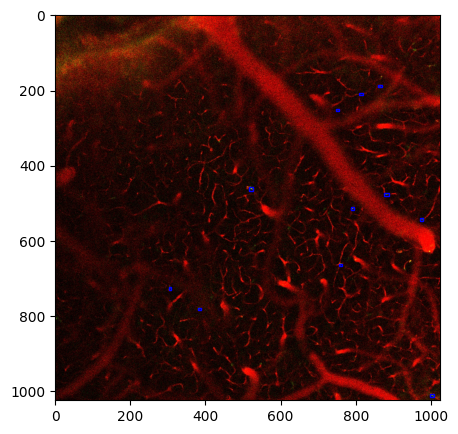

In [10]:
#function to visualize the bounding boxes to make sure im making the dataset properly
def plot_img_box(img, target):
    #plot the image and bb
    #bb def: xmin ymin width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in (target["boxes"]):
        x, y, width, height = box[0], box[1], box[2] - box[0], box[3] - box[1]
        rect = patches.Rectangle(
        (x, y),
        width, height,
        linewidth = 1,
        edgecolor = 'b',
        facecolor = 'none'
        )
        #overlay bb ontop of image
        a.add_patch(rect)
    plt.show()
    
#plotting the img with bb
img, target = dataset[1]
num_bb = len(target['boxes'])
print(f'Ground Truth Neutrophil Count: {num_bb}\n')
plot_img_box(img, target)

In [11]:
# Send train=True for training transforms and False for val/test transforms
def get_transform(train):
  if train:
    return A.Compose(
      [
        A.HorizontalFlip(p=0.25),
        A.Rotate(p=0.25),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.20),
        A.VerticalFlip(p=0.20),
        A.RandomSizedBBoxSafeCrop(height=512, width=512, p=0.25),
        A.GaussianBlur(blur_limit=3, p=0.10),
        A.JpegCompression(p=0.10),
        A.CoarseDropout(max_holes=15, max_height=10, max_width=10, p=0.15),
        #elastic transform, vertical flip, bboxsaferandomcrop, verticallip, gaussian blur   
        #ToTensorV2 converts image to pytorch tensor without div by 255
        ToTensorV2(p=1.0) 
      ],
      bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}
    )
  else:
    return A.Compose(
      [ToTensorV2(p=1.0)],
      bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}
    )

In [12]:
#using our neutrophil dataset and defined transforms from above
dataset = NeutrophilDataset(files_dir, transforms=get_transform(train=True))
dataset_test = NeutrophilDataset(files_dir, transforms=get_transform(train=False))

#split test and train
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

#define training and val dataloaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=16,
    shuffle=True,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=16,
    shuffle=False,
    collate_fn=utils.collate_fn
)

In [15]:
def get_object_detection_model(num_classes):
    model = torchvision.models.detection.fcos_resnet50_fpn(pretrained=True)  # load an object detection model pre-trained on COCO
    #freeze backbone
    for name, param in model.backbone.named_parameters():
        if 'weight' in name or 'bias' in name:
            param.requires_grad = False
    
    #unfreeze all other layers
    for name, param in model.named_parameters():
        if 'backbone' not in name:
            param.requires_grad = True
    
    #Modify classification head to output num_classes
    num_anchors = model.head.classification_head.num_anchors
    model.head.classification_head.num_classes = num_classes
    out_channels = model.head.classification_head.conv[9].out_channels
    cls_logits = torch.nn.Conv2d(out_channels, num_anchors * num_classes, kernel_size=3, stride=1, padding=1)
    torch.nn.init.normal_(cls_logits.weight, std=0.01)
    torch.nn.init.constant_(cls_logits.bias, -math.log((1 - 0.01) / 0.01))
    model.head.classification_head.cls_logits = cls_logits
    
    #Modify the regression head to output num_classes * 4 (ltbr)
    bbox_pred = torch.nn.Conv2d(out_channels, num_anchors * 4, kernel_size=3, stride=1, padding=1)
    torch.nn.init.normal_(bbox_pred.weight, std=0.01)
    torch.nn.init.constant_(bbox_pred.bias, 0)
    model.head.regression_head.bbox_pred = bbox_pred
    
    #Modify centerness head to output num_classes
    centerness = torch.nn.Conv2d(out_channels, num_anchors * 1, kernel_size=3, stride=1, padding=1)
    torch.nn.init.normal_(centerness.weight, std=0.01)
    torch.nn.init.constant_(centerness.bias, 0)
    model.head.regression_head.bbox_ctrness = centerness
    
    return model
    

**TRAIN SETUP**

In [16]:
#gpu training
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2 #neutrophil (1) and background class (0)

model = get_object_detection_model(num_classes)
model.to(device)

#construct optim
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0055, momentum=0.9, weight_decay=0.0001)

#learning rate scheduler to decrease lr by 10x every 3 epochs (not to overshoot minimum)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[75, 150, 200, 225], gamma=0.75)

In [17]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
    
    def forward(self, inputs, targets):
        
        #CrossEntropy
        BCE_loss = torch.nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        #modulating factor
        pt = torch.exp(-BCE_loss)
        modulating_factor = (1 - pt)**self.gamma
        
        #computer final loss
        loss = modulating_factor * BCE_loss
        
        return loss.mean()

**CHECK GPU**

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


**TRAINING**

In [19]:
num_epochs = 250
criterion = FocalLoss(gamma=2.0)

for epoch in range(num_epochs):
    #training at each epoch
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=1)
    #update lr
    lr_scheduler.step()
    #eval
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [0/8]  eta: 0:00:31  lr: 0.000790  loss: 2.7163 (2.7163)  classification: 1.1056 (1.1056)  bbox_regression: 0.9049 (0.9049)  bbox_ctrness: 0.7058 (0.7058)  time: 3.9158  data: 0.6331  max mem: 4021
Epoch: [0]  [1/8]  eta: 0:00:18  lr: 0.001575  loss: 2.6873 (2.7018)  classification: 1.1056 (1.1072)  bbox_regression: 0.8708 (0.8879)  bbox_ctrness: 0.7058 (0.7067)  time: 2.6145  data: 0.6997  max mem: 4051
Epoch: [0]  [2/8]  eta: 0:00:13  lr: 0.002360  loss: 2.6873 (2.6928)  classification: 1.1056 (1.0984)  bbox_regression: 0.8913 (0.8890)  bbox_ctrness: 0.7058 (0.7055)  time: 2.1796  data: 0.7222  max mem: 4051
Epoch: [0]  [3/8]  eta: 0:00:09  lr: 0.003145  loss: 2.6749 (2.6528)  classification: 1.0806 (1.0761)  bbox_regression: 0.8708 (0.8746)  bbox_ctrness: 0.7030 (0.7021)  time: 1.9318  data: 0.7037  max mem: 4051
Epoch: [0]  [4/8]  eta: 0:00:07  lr: 0.003930  loss: 2.6749 (2.5985)  classification: 1.0806 (1.0331)  bbox_regression: 0.8708 (0.8669)  bbox_ctrness: 0.7030 (0

In [ ]:
#original prediction and iou threshold
def apply_nms(orig_prediction, iou_thresh = 0.3):
    #torchvis returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction["boxes"].cpu(), orig_prediction["scores"].cpu(), iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'].cpu()[keep]
    final_prediction['scores'] = final_prediction['scores'].cpu()[keep]
    final_prediction['labels'] = final_prediction['labels'].cpu()[keep]
    
    return final_prediction


#function to convert tensor back to PIL img
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

In [ ]:
# pick one image from the test set
img, target = dataset_test[4]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
  prediction = model([img.to(device)])[0]

nms_prediction = apply_nms(prediction, iou_thresh=0.01)
num_predictions = len(nms_prediction['boxes'])

print(f'Neutrophil count: {num_predictions}\n')
print('MODEL OUTPUT\n')
plot_img_box(torch_to_pil(img), prediction)



**SAVE MODEL**
Make sure to add [filename].pt to the end of SAVE_PATH

In [ ]:
SAVE_PATH  = "D:/Abdallah/Venvs/tvenv/notebook/saved_models/fasterRCNN_resnet50_v2.pt"
torch.save(model, SAVE_PATH)